In [ ]:
import os
import yaml
import shutil
import glob
import cv2
from tqdm import tqdm
from ultralytics import YOLO

# 데이터 포맷 변경

In [ ]:
# 데이터셋 경로 설정
WIDER_PATH = "WIDER_FACE"
ANNOTATION_TRAIN = os.path.join(WIDER_PATH, "wider_face_split/wider_face_train_bbx_gt.txt")
ANNOTATION_VAL = os.path.join(WIDER_PATH, "wider_face_split/wider_face_val_bbx_gt.txt")
IMAGE_TRAIN_PATH = os.path.join(WIDER_PATH, "WIDER_train/images")
IMAGE_VAL_PATH = os.path.join(WIDER_PATH, "WIDER_val/images")
YOLO_LABELS_TRAIN = os.path.join(WIDER_PATH, "labels/train")
YOLO_LABELS_VAL = os.path.join(WIDER_PATH, "labels/val")

os.makedirs(YOLO_LABELS_TRAIN, exist_ok=True)
os.makedirs(YOLO_LABELS_VAL, exist_ok=True)

def convert_wider_to_yolo(annotation_file, img_base_path, output_label_path):
    with open(annotation_file, "r") as f:
        lines = f.readlines()

    i = 0
    while i < len(lines):
        img_rel_path = lines[i].strip()

        # 파일 확장자가 jpg인지 확인
        if not img_rel_path.endswith(".jpg"):
            print(f"WARNING: 잘못된 이미지 경로 -> {img_rel_path}")
            i += 1
            continue  # 다음 줄로 넘어감

        img_path = os.path.join(img_base_path, img_rel_path)
        img_basename = os.path.splitext(os.path.basename(img_path))[0]
        label_file = os.path.join(output_label_path, f"{img_basename}.txt")
        i += 1

        if not os.path.exists(img_path):
            print(f"ERROR: 이미지 없음 -> {img_path}")
            continue

        try:
            face_count = int(lines[i].strip())
        except ValueError:
            print(f"WARNING: 얼굴 개수 변환 실패 -> {lines[i].strip()}")
            i += 1
            continue

        i += 1
        img = cv2.imread(img_path)
        if img is None:
            print(f"ERROR: 이미지 로드 실패 -> {img_path}")
            continue
        img_h, img_w, _ = img.shape

        yolo_lines = []
        for _ in range(face_count):
            try:
                bbox = list(map(int, lines[i].strip().split()[:4]))
                i += 1
            except ValueError:
                print(f"WARNING: 잘못된 바운딩 박스 데이터 -> {lines[i].strip()}")
                continue

            x, y, w, h = bbox
            x_center = (x + w / 2) / img_w
            y_center = (y + h / 2) / img_h
            w /= img_w
            h /= img_h

            yolo_lines.append(f"0 {x_center:.6f} {y_center:.6f} {w:.6f} {h:.6f}")

        with open(label_file, "w") as f:
            f.write("\n".join(yolo_lines))

    print(f"YOLO 라벨 변환 완료: {output_label_path}")


# YOLO 데이터셋 생성
convert_wider_to_yolo(ANNOTATION_TRAIN, IMAGE_TRAIN_PATH, YOLO_LABELS_TRAIN)
convert_wider_to_yolo(ANNOTATION_VAL, IMAGE_VAL_PATH, YOLO_LABELS_VAL)

# 이미지 및 라벨 정리
def organize_dataset(image_dir, label_dir, output_image_dir, output_label_dir):
    os.makedirs(output_image_dir, exist_ok=True)
    os.makedirs(output_label_dir, exist_ok=True)

    for root, _, files in os.walk(image_dir):
        for file in files:
            if file.endswith(".jpg"):
                img_path = os.path.join(root, file)
                label_path = os.path.join(label_dir, file.replace(".jpg", ".txt"))

                if os.path.exists(label_path):
                    shutil.copy(img_path, os.path.join(output_image_dir, file))
                    shutil.copy(label_path, os.path.join(output_label_dir, file.replace(".jpg", ".txt")))

    print(f"데이터셋 정리 완료: {output_image_dir}, {output_label_dir}")

# 학습 및 검증 데이터셋 구성
DATASET_PATH = "dataset"
organize_dataset(IMAGE_TRAIN_PATH, YOLO_LABELS_TRAIN, f"{DATASET_PATH}/images/train", f"{DATASET_PATH}/labels/train")
organize_dataset(IMAGE_VAL_PATH, YOLO_LABELS_VAL, f"{DATASET_PATH}/images/val", f"{DATASET_PATH}/labels/val")



YOLO 라벨 변환 완료: WIDER_FACE/labels/train
YOLO 라벨 변환 완료: WIDER_FACE/labels/val
데이터셋 정리 완료: dataset/images/train, dataset/labels/train
데이터셋 정리 완료: dataset/images/val, dataset/labels/val


## 데이터 포맷 변환

Wider Face 데이터셋과 YOLO가 요규하는 데이터 포맷이 다르다. 따라서 적절한 변환 과정이 필요하다.

- Wider Face 데이터셋 포맷
    - 얼굴 검출을 위한 데이터셋
    - .txt 형식의 annotation
> x$\quad$y$\quad$w$\quad$h$\quad$blur$\quad$expression$\quad$illumination$\quad$occlusion$\quad$pose$\quad$invalid

- YOLO 데이터 포맷
 - 객체 탐지를 위해 아래 형식의 .txt annotation 파일이 필요
> class$\quad$x_center$\quad$y_senter$\quad$width$\quad$height




### 변환 과정
1. class label 통일
    - Wider Face 데이터셋은 얼굴 탐지를 위한 데이터셋이기 때문에 모든 객체는 face class 하나로 간주한다.
    - YOLO에서는 class num을 사용하므로, face를 0으로 설정

2. 좌표 변환
    - YOLO는 bounding box 중심 좌표를 사용하므로, (x, y, w, h) 좌표를 (x_center, y_center, width, height) 형식으로 변환한다.
    - YOLO는 이미지 크기에 대해 상대적인 좌표 값을 요구하므로, 전체 이미지 너비 W, 높이 H로 나누어 정규화해야 한다.

3. 파일 저장 형식 변경
    - YOLO는 이미지와 동일한 이름의 .txt 파일이 필요하다.
    - 예를 들어, 이미지 파일이 img_001.jpg라면, label 파일은 img_001.txt로 저장해야 한다.






Wider Face 데이터셋에는 얼굴 개수가 0인 경우도 존재한다.

이때 line[i].strip()이 0이므로, bounding box 정보가 없는 상태에서 다음 줄을 읽으려고 한다.

하지만 0 0 0 0 0 0 0 0 0 0과 같은 라인은 이미지 파일명이 아니기 때문에 "잘못된 이미지 경로"라고 뜨게 코드가 구성되어 있다.

In [ ]:
dataset_yaml = {
    "train": os.path.abspath("dataset/images/train"),
    "val": os.path.abspath("dataset/images/val"),
    "nc": 1,
    "names": ["face"]
}

with open("dataset.yaml", "w") as f:
    yaml.dump(dataset_yaml, f, default_flow_style=False)

print("✅ dataset.yaml 저장 완료:", os.path.abspath("dataset.yaml"))


✅ dataset.yaml 저장 완료: /home/20203057/dataset.yaml


## yaml 파일
YOLO은 학습할 때 데이터셋 정보를 직접 코드에서 입력하는 것이 아니라, .yaml파일을 참조한다.
- train/val/test 데이터가 어디에 있는지 YOLO 모델이 알 수 있도록 경로를 지정한다.
- YOLO는 객체 탐지를 위해 class별 번호를 사용하므로, 클래스 이름을 명시해줘야 한다.
- ultralytics YOLO는 .yaml 파일을 읽어서 자동으로 데이터셋을 로드하고, 훈련할 수 있도록 설계되어 있다.

In [ ]:
# 3. YOLO 모델 학습
yolo_model = YOLO("yolov8n.pt")  # 사전 학습된 YOLO 모델 사용
yolo_model.train(data="dataset.yaml", epochs=10, imgsz=512, batch=8)

New https://pypi.org/project/ultralytics/8.3.82 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.78 🚀 Python-3.10.12 torch-2.6.0+cu124 CUDA:0 (NVIDIA GeForce RTX 2080 Ti, 10823MiB)
engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=dataset.yaml, epochs=10, time=None, patience=100, batch=8, imgsz=512, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train11, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_fr

train: Scanning /home/20203057/dataset/labels/train.cache... 12880 images, 4 backgrounds, 1 corrupt: 100%|██████████| 12880/12880 [00:00<?, ?it/s]

train: WARNING ⚠️ /home/20203057/dataset/images/train/2_Demonstration_Protesters_2_231.jpg: 1 duplicate labels removed
train: WARNING ⚠️ /home/20203057/dataset/images/train/37_Soccer_Soccer_37_851.jpg: 1 duplicate labels removed
train: WARNING ⚠️ /home/20203057/dataset/images/train/54_Rescue_rescuepeople_54_29.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     1.0254]
train: WARNING ⚠️ /home/20203057/dataset/images/train/7_Cheering_Cheering_7_17.jpg: 1 duplicate labels removed


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Scanning /home/20203057/dataset/labels/val.cache... 3226 images, 0 backgrounds, 1 corrupt: 100%|██████████| 3226/3226 [00:00<?, ?it/s]

val: WARNING ⚠️ /home/20203057/dataset/images/val/21_Festival_Festival_21_604.jpg: 1 duplicate labels removed
val: WARNING ⚠️ /home/20203057/dataset/images/val/39_Ice_Skating_iceskiing_39_583.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [      1.002]


Plotting labels to runs/detect/train11/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)


2025/03/04 00:30:16 INFO mlflow.bedrock: Enabled auto-tracing for Bedrock. Note that MLflow can only trace boto3 service clients that are created after this call. If you have already created one, please recreate the client by calling `boto3.client`.
2025/03/04 00:30:16 INFO mlflow.tracking.fluent: Autologging successfully enabled for boto3.
2025/03/04 00:30:16 INFO mlflow.tracking.fluent: Autologging successfully enabled for statsmodels.


MLflow: logging run_id(654a8c52933f4d1c8538fdc86de85a2e) to http://127.0.0.1:5000
MLflow: disable with 'yolo settings mlflow=False'
MLflow: WARNING ⚠️ Failed to initialize: API request to http://127.0.0.1:5000/api/2.0/mlflow/runs/log-batch failed with exception HTTPConnectionPool(host='127.0.0.1', port=5000): Max retries exceeded with url: /api/2.0/mlflow/runs/log-batch (Caused by ResponseError('too many 500 error responses'))
MLflow: WARNING ⚠️ Not tracking this run
TensorBoard: model graph visualization added ✅
Image sizes 512 train, 512 val
Using 1 dataloader workers
Logging results to runs/detect/train11
Starting training for 10 epochs...
Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/10      5.39G      1.893      1.479      1.157         21        512: 100%|██████████| 1610/1610 [13:14<00:00,  2.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 202/202 [02:26<00:00,  1.38it/s]


                   all       3225      39675      0.696      0.342      0.383      0.185

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/10      4.48G      1.745      1.084      1.094         74        512: 100%|██████████| 1610/1610 [05:20<00:00,  5.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 202/202 [00:37<00:00,  5.38it/s]


                   all       3225      39675      0.713      0.377      0.432      0.212

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/10      3.75G        1.7      1.022      1.079        226        512: 100%|██████████| 1610/1610 [05:16<00:00,  5.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 202/202 [00:37<00:00,  5.36it/s]


                   all       3225      39675      0.724      0.397      0.461      0.231

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/10      3.92G       1.65      0.968      1.062        173        512: 100%|██████████| 1610/1610 [05:17<00:00,  5.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 202/202 [00:37<00:00,  5.35it/s]


                   all       3225      39675      0.748      0.412      0.477      0.241

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/10      5.21G      1.608     0.9136      1.044         53        512: 100%|██████████| 1610/1610 [05:16<00:00,  5.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 202/202 [00:37<00:00,  5.36it/s]


                   all       3225      39675      0.756      0.419      0.485      0.249

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/10       5.1G      1.577     0.8762      1.038         24        512: 100%|██████████| 1610/1610 [05:16<00:00,  5.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 202/202 [00:37<00:00,  5.41it/s]


                   all       3225      39675      0.766      0.436      0.502      0.257

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/10      5.24G      1.547     0.8423      1.028         19        512: 100%|██████████| 1610/1610 [05:17<00:00,  5.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 202/202 [00:38<00:00,  5.28it/s]


                   all       3225      39675      0.773      0.441      0.509      0.267

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/10      3.87G      1.516     0.8109      1.016         93        512: 100%|██████████| 1610/1610 [05:17<00:00,  5.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 202/202 [00:37<00:00,  5.32it/s]


                   all       3225      39675      0.776      0.445      0.519      0.271

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/10      4.38G      1.495     0.7853      1.007         79        512: 100%|██████████| 1610/1610 [05:15<00:00,  5.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 202/202 [00:37<00:00,  5.37it/s]


                   all       3225      39675      0.782      0.464      0.533      0.281

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/10       5.1G      1.469     0.7551     0.9993         73        512: 100%|██████████| 1610/1610 [05:17<00:00,  5.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 202/202 [00:37<00:00,  5.41it/s]


                   all       3225      39675      0.786       0.46      0.533      0.283

10 epochs completed in 1.153 hours.
Optimizer stripped from runs/detect/train11/weights/last.pt, 6.2MB
Optimizer stripped from runs/detect/train11/weights/best.pt, 6.2MB

Validating runs/detect/train11/weights/best.pt...
Ultralytics 8.3.78 🚀 Python-3.10.12 torch-2.6.0+cu124 CUDA:0 (NVIDIA GeForce RTX 2080 Ti, 10823MiB)
Model summary (fused): 72 layers, 3,005,843 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 202/202 [01:35<00:00,  2.11it/s]


                   all       3225      39675      0.786       0.46      0.533      0.283
Speed: 0.1ms preprocess, 0.8ms inference, 0.0ms loss, 2.2ms postprocess per image
Results saved to runs/detect/train11
🏃 View run train9 at: http://127.0.0.1:5000/#/experiments/269523146541905943/runs/654a8c52933f4d1c8538fdc86de85a2e
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/269523146541905943
MLflow: results logged to http://127.0.0.1:5000
MLflow: disable with 'yolo settings mlflow=False'


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7fafd5904820>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.048048, 

In [ ]:
# 4. 평가 수행
yolo_model.val(data="dataset.yaml")

Ultralytics 8.3.78 🚀 Python-3.10.12 torch-2.6.0+cu124 CUDA:0 (NVIDIA GeForce RTX 2080 Ti, 10823MiB)
Model summary (fused): 72 layers, 3,005,843 parameters, 0 gradients, 8.1 GFLOPs


val: Scanning /home/20203057/dataset/labels/val.cache... 3226 images, 0 backgrounds, 1 corrupt: 100%|██████████| 3226/3226 [00:00<?, ?it/s]

val: WARNING ⚠️ /home/20203057/dataset/images/val/21_Festival_Festival_21_604.jpg: 1 duplicate labels removed
val: WARNING ⚠️ /home/20203057/dataset/images/val/39_Ice_Skating_iceskiing_39_583.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [      1.002]



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 404/404 [00:54<00:00,  7.35it/s]


                   all       3225      39675      0.787       0.46      0.534      0.283
Speed: 0.2ms preprocess, 2.1ms inference, 0.0ms loss, 1.1ms postprocess per image
Results saved to runs/detect/train112


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7fafcb40a5c0>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.048048, 

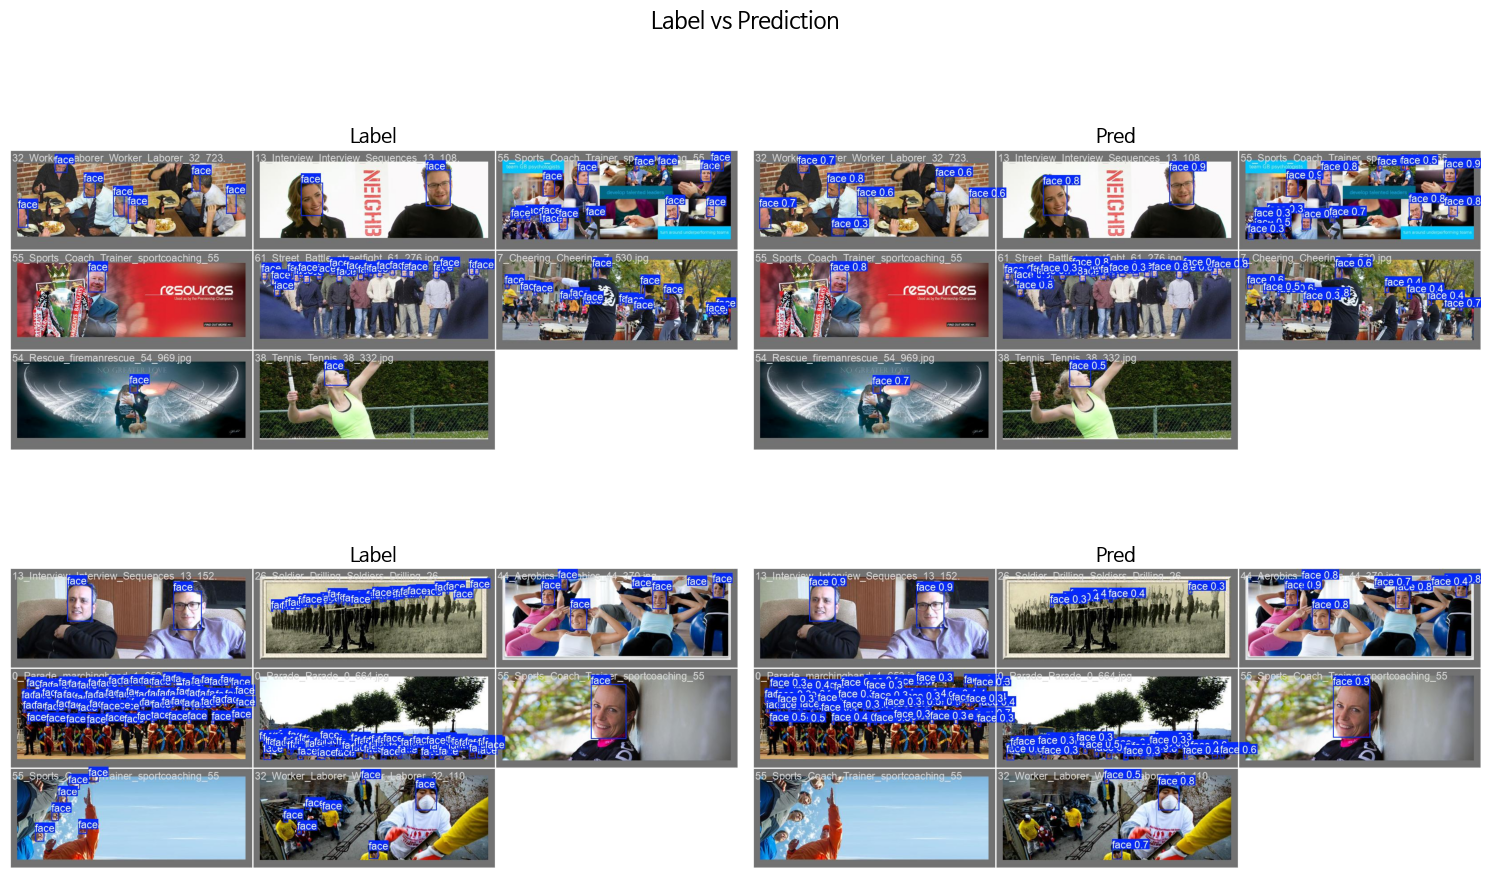

In [ ]:
import matplotlib.pyplot as plt
import cv2

img_list = [
    ("runs/detect/train112/val_batch0_labels.jpg", "runs/detect/train112/val_batch0_pred.jpg"),
    ("runs/detect/train112/val_batch1_labels.jpg", "runs/detect/train112/val_batch1_pred.jpg"),
    ("runs/detect/train112/val_batch2_labels.jpg", "runs/detect/train112/val_batch2_pred.jpg")
]

fig, axes = plt.subplots(2, 2, figsize=(15, 10))

for i, (label_img_path, pred_img_path) in enumerate(img_list):
    row = i // 2
    col = i % 2

    label_img = cv2.imread(label_img_path)
    label_img = cv2.cvtColor(label_img, cv2.COLOR_BGR2RGB)

    pred_img = cv2.imread(pred_img_path)
    pred_img = cv2.cvtColor(pred_img, cv2.COLOR_BGR2RGB)

    axes[row, 0].imshow(label_img)
    axes[row, 0].axis("off")
    axes[row, 0].set_title("Label", fontsize=14)

    axes[row, 1].imshow(pred_img)
    axes[row, 1].axis("off")
    axes[row, 1].set_title("Pred", fontsize=14)

plt.suptitle("Label vs Prediction", fontsize=16)
plt.tight_layout()
plt.show()


## Label과 Prediction 비교
결과를 비교해보면 측면 얼굴이나 아래에서 찍힌 얼굴은 제대로 감지하지 못하는 것을 볼 수 있다. 또한 작은 얼굴도 감지를 못한다.

여기에는 여러가지 이유가 있을 수 있다.

- 데이터 불균형
    - 데이터셋에 정면 얼굴의 비율이 더 많을 가능성이 높다.
        - annotation을 확인해보니 occlusion 정보가 포함된 얼굴의 비율이 낮은 것을 확인할 수 있었다.

- 작은 얼굴 인식 문제
    - 낮은 해상도에서 촬영된 이미지에서 얼굴이 작게 나타나는 경우, 픽셀 수가 적기 때문에 모델의 특징을 제대로 학습하지 못할 가능성이 있다.


이와 같은 문제를 해결하기 위해서는 data augmentation을 하거나 data filtering, oversampling을 하여 데이터의 균형을 조정하는 방법을 사용할 수 있을 것 같다. 또한 작은 얼굴이나 다양한 각도를 더 잘 감지할 수 있도록 더 높은 해상도로 학습시키거나 stride를 줄여 학습을 시킬 수 있다.

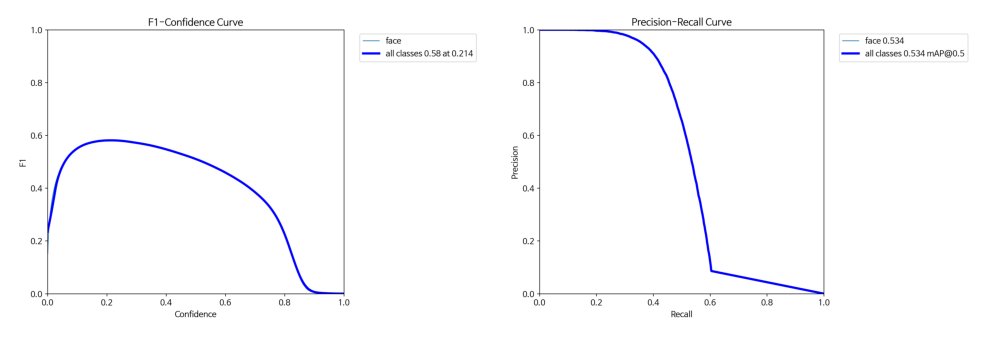

In [ ]:
img_list = [
    "runs/detect/train112/F1_curve.png",
    "runs/detect/train112/PR_curve.png"
]

fig, axes = plt.subplots(1, 2, figsize=(10, 10))

for i, (ax, img_path) in enumerate(zip(axes.flat, img_list)):
    img = plt.imread(img_path)
    ax.imshow(img)
    ax.axis("off")

plt.tight_layout()
plt.show()

F1-Confidence Curve를 보면 최적의 Confidence 임계값은 0.214임을 확인할 수 있다. 이를 활용해 YOLO의 Confidence Threshold를 조정할 필요가 있다.

Precision-Recall Curve를 보면 Recall이 높아질수록 Precision이 급격히 낮아진다. 이는 모델이 잘못된 얼굴 검출을 많이 한다는 것을 의미한다.

YOLO의 디폴트 Confidence Threshold은 0.25로 알고 있다. 이것이 측면 얼굴이나 가려진 얼굴을 감지를 못하는 이유일 수 있다. 따라서 confidence threshold 값을 조금 낮추어 실험해보는 것도 좋은 방법인 것 같다.

### 느낀점
확실히 모델을 학습시키는 것보다 데이터를 그 모델에 맞추어 변환하는 작업이 더 어려운 것 같다. 데이터셋의 포맷이 모델이 기대하는 형태와 다를 경우, 전처리 과정에서 많은 시간을 투자해야 한다. 특히, bounding box annotation을 YOLO 포맷에 맞추는 과정에서 예상치 못한 오류가 발생하였다. 이 과저에서 데이터가 잘못 변환되는 학습 자체가 제대로 이루어지지 않기 때문에 데이터 전처리의 중요성을 다시 한 번 느꼈다.